In [1]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bananapple","key":"20fb6b8f4a62f473137bd0700db9a067"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d die9origephit/children-vs-adults-images

 18% 5.00M/27.7M [00:00<00:00, 52.2MB/s]
100% 27.7M/27.7M [00:00<00:00, 160MB/s] 


In [5]:
#압축풀기
import zipfile

local_zip = '/content/children-vs-adults-images.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/adult-children')
zip_ref.close()

In [6]:
#https://www.kaggle.com/datasets/die9origephit/children-vs-adults-images
#캐글 어린이 vs 어른 

# 경로지정

In [7]:
base_dir='/content/adult-children'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [8]:
train_adult_dir= os.path.join(train_dir,'adults')
train_children_dir= os.path.join(train_dir,'children')

test_adult_dir= os.path.join(test_dir,'adults')
test_children_dir= os.path.join(test_dir,'children')

In [9]:
train_adult_list= os.listdir(train_adult_dir)
train_children_list= os.listdir(train_children_dir)

test_adult_list=os.listdir(test_adult_dir)
test_children_list= os.listdir(test_children_dir)

In [10]:
print(len(train_adult_list))
print(len(train_children_list))

340
340


# imagegenerator

In [11]:
batch=32
img_height=250
img_width=250

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 )
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(train_dir,
                                                   batch_size=batch,
                                                   class_mode='binary',
                                                   target_size=(img_width,img_height)
                                                   )
test_genrator= test_datagen.flow_from_directory(test_dir,
                                                batch_size=batch,
                                                class_mode='binary',
                                                target_size=(img_width,img_height)
                                                )

Found 680 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [13]:
print(train_generator.class_indices.items())
print(train_generator.class_indices)

dict_items([('adults', 0), ('children', 1)])
{'adults': 0, 'children': 1}


# 모델만들기

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.applications import MobileNet, Xception, ResNet50, InceptionV3
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.engine.sequential import Sequential
from tensorflow import keras
from keras import regularizers

In [17]:
#pre-trainded model 불러오기
base_model=Xception(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

83683744/83683744 [==============================] - 0s 0us/step


In [18]:
#특징 추출기

base_model.trainabel=False

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [39]:
model=Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_6 (Flatten)         (None, 131072)            0         
                                                                 
 dense_14 (Dense)            (None, 16)                2097168   
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 1)                

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics='accuracy'
              )

# 학습하기

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping=EarlyStopping(monitor='val_loss', #val_loss 값이 개선되었을 때
                            patience=5 #5회 epoch 동안 val_loss가 개선되지 않는다면 종료
                            )

In [44]:
history=model.fit(train_generator,
                  validation_data=test_genrator,
                  callbacks=[earlystopping],
                  epochs=5
                  )

Epoch 1/5
22/22 [==============================] - 18s 780ms/step - loss: 0.1465 - accuracy: 0.9515 - val_loss: 0.2746 - val_accuracy: 0.8500
Epoch 2/5
22/22 [==============================] - 18s 800ms/step - loss: 0.1404 - accuracy: 0.9471 - val_loss: 0.2517 - val_accuracy: 0.8833
Epoch 3/5
22/22 [==============================] - 18s 797ms/step - loss: 0.1184 - accuracy: 0.9588 - val_loss: 0.2370 - val_accuracy: 0.8833
Epoch 4/5
22/22 [==============================] - 18s 776ms/step - loss: 0.0982 - accuracy: 0.9647 - val_loss: 0.2507 - val_accuracy: 0.8750
Epoch 5/5
22/22 [==============================] - 18s 779ms/step - loss: 0.1183 - accuracy: 0.9574 - val_loss: 0.2430 - val_accuracy: 0.9083


In [45]:
#모델 저장하기
from keras.models import load_model
model.save('어린이vs어른.h5')

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


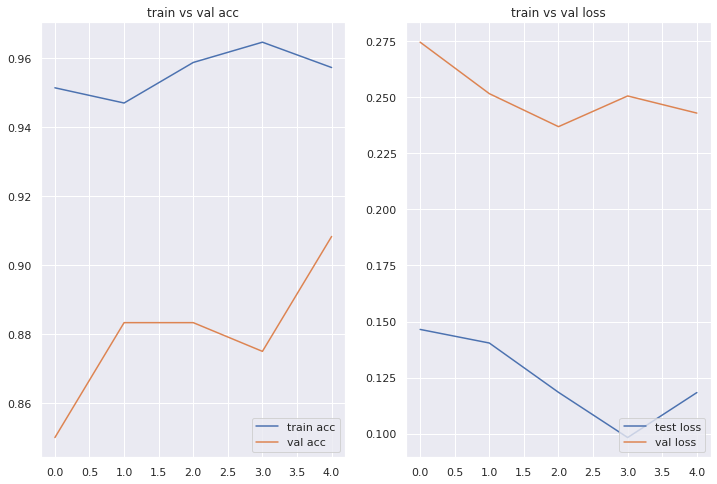

In [49]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epoch_range=range(5)

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label='train acc')
plt.plot(epoch_range, val_acc, label='val acc')
plt.legend(loc='lower right')
plt.title('train vs val acc')

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label='test loss')
plt.plot(epoch_range, val_loss, label='val loss')
plt.legend(loc='lower right')
plt.title('train vs val loss')

plt.show()

In [51]:
#test데이터 정확도 확인
test_loss, test_acc = model.evaluate(test_genrator,verbose=2)#verbose는 그냥 출력문을 어떤식으로 보여줄까 묻는거 0은 출력문 안보여줌 1은 반만 2는 전체 다 출력

print('\n테스트 정확도:', test_acc)
print('\n테스트 손실값"',test_loss)

4/4 - 1s - loss: 0.2430 - accuracy: 0.9083 - 766ms/epoch - 191ms/step

테스트 정확도: 0.9083333611488342

테스트 손실값" 0.24300260841846466


# 시각화

In [52]:
import cv2
import glob

test_img_list=[]

test_img_name_list=glob.glob('테스트용/*')

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(img_width, img_height))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0

    test_img_list.append(src_img)

1/1 [==============================] - 0s 22ms/step


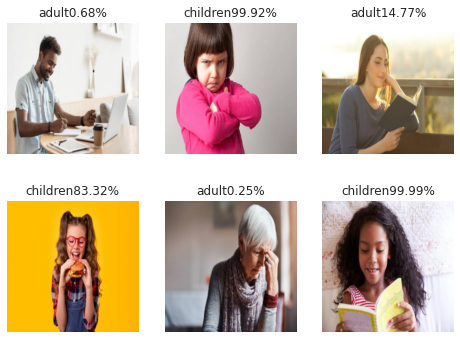

In [55]:
pred=model.predict(np.array(test_img_list))

plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
  plt.subplot(2,3,i+1)
  prob='{0:0.2f}'.format(100*max(pred[i]))
  if(pred[i]>=0.5):
    title_str='children' + prob+'%'
    plt.title(title_str)

  else:
    title_str='adult' + prob + '%'
    plt.title(title_str)

  plt.imshow(test_img_list[i])
  plt.axis('off')
plt.show()